In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import lognorm, gamma, expon, gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
df = pd.read_excel(r"..\data\raw\datos_crudos.xlsx").dropna()
df.columns = ['ano', 'evento', 'categoria', 'decreto', 'provincia', 'canton', 'latitud', 'longitud', 'tipologia', 'total']
df = df.drop(columns=['categoria', 'decreto', 'evento'])
df['tipologia'] = df['tipologia'].str.strip().str.upper().str.replace(r"\s+", " ", regex=True)

In [36]:
df

,ano,provincia,canton,latitud,longitud,tipologia,total
1,2005,Cartago,Alvarado,9.917082,-83.809449,CARRETERAS,2.062700e+07
2,2005,Cartago,Alvarado,9.917082,-83.809449,VIVIENDA,5.363636e+08
3,2005,Cartago,Alvarado,9.917082,-83.809449,SISTEMAS ELÉCTRICOS,6.210540e+06
4,2005,Cartago,Alvarado,9.917082,-83.809449,SISTEMAS DE INFOCOMUNICACIONES,5.440422e+06
5,2005,Cartago,Alvarado,9.917082,-83.809449,PRIMER IMPACTO,3.254603e+07
...,...,...,...,...,...,...,...
2491,2022,San José,Pérez Zeledón,9.384718,-83.706217,EDIFICIOS PÚBLICOS,5.013908e+09
2492,2022,San José,Pérez Zeledón,9.384718,-83.706217,SOCIAL,6.000000e+05
2493,2023,Alajuela,San Carlos,10.322721,-84.430822,CARRETERAS,2.635822e+09
2494,2023,Alajuela,San Carlos,10.322721,-84.430822,PUENTES,1.500000e+08


In [2]:
df['provincia'].unique()

array(['Cartago', 'Heredia', 'Limón', 'San José', 'Alajuela',
       'Guanacaste', 'Puntarenas'], dtype=object)

In [37]:
df['tipologia'].value_counts()

tipologia
CARRETERAS                        379
PUENTES                           304
AGROPECUARIO                      262
PRIMER IMPACTO                    245
ALCANTARILLAS Y VADOS             234
VIVIENDA                          191
RÍOS Y QUEBRADAS                  187
SISTEMAS DE AGUA                  163
EDIFICIOS PÚBLICOS                104
CENTROS EDUCATIVOS                 81
OBRAS CORRECTIVAS                  53
SOCIAL                             40
SISTEMAS ELÉCTRICOS                34
SISTEMAS DE INFOCOMUNICACIONES     26
DIVERSAS                           10
FERROVÍAS                           9
AERODROMOS                          9
SISTEMAS DE RIEGO                   6
ACTIVIDAD EMPRESARIAL               6
AMBIENTE                            6
OBRAS DIVERSAS                      1
ENERGÍA (POLIDUCTO)                 1
Name: count, dtype: int64

In [38]:
map_tipos = {
    # INFRAESTRUCTURA
    'CARRETERAS': 'INFRAESTRUCTURA',
    'PUENTES': 'INFRAESTRUCTURA',
    'ALCANTARILLAS Y VADOS': 'INFRAESTRUCTURA',
    'EDIFICIOS PUBLICOS': 'INFRAESTRUCTURA',
    'CENTROS EDUCATIVOS': 'INFRAESTRUCTURA',
    'SISTEMAS DE INFOCOMUNICACION': 'INFRAESTRUCTURA',
    'FERROVIAS': 'INFRAESTRUCTURA',
    'AERODROMOS': 'INFRAESTRUCTURA',
    'OBRAS DIVERSAS': 'INFRAESTRUCTURA',

    # ENERGIA
    'SISTEMAS ELECTRICOS': 'ENERGÍA',
    'ENERGIA POLIDUCTO': 'ENERGÍA',
    'ENERGIA (POLIDUCTO)': 'ENERGÍA',

    # HIDRICO
    'RIOS Y QUEBRADAS': 'HÍDRICO',
    'SISTEMAS DE AGUA': 'HÍDRICO',
    'SISTEMAS DE RIEGO': 'HÍDRICO',
    'OBRAS CORRECTIVAS': 'HÍDRICO',

    # SOCIAL
    'SOCIAL': 'SOCIAL',
    'VIVIENDA': 'SOCIAL',
    'PRIMER IMPACTO': 'SOCIAL',

    # PRODUCTIVO
    'AGROPECUARIO': 'PRODUCTIVO',
    'ACTIVIDAD EMPRESARIAL': 'PRODUCTIVO',

    # OTROS
    'AMBIENTE': 'OTROS',
    'DIVERSAS': 'OTROS'
}

df['categoria'] = df['tipologia'].str.upper().map(map_tipos).fillna('OTROS')
df = df.drop(columns=["tipologia"])
orden_provincias = ["San José", "Alajuela", "Cartago", "Heredia", "Guanacaste", "Puntarenas", "Limón"]
df["provincia"] = pd.Categorical(df["provincia"], categories=orden_provincias, ordered=True)

In [39]:
df['categoria'].value_counts()

categoria
INFRAESTRUCTURA    1008
SOCIAL              476
OTROS               377
PRODUCTIVO          268
HÍDRICO             222
Name: count, dtype: int64

### Análisis Exploratorio de Los Datos

#### Distribución de Eventos por Categoría


Distribución de Eventos por Categoría

         categoria  num_eventos  proporcion
1  INFRAESTRUCTURA         1008    0.428754
4           SOCIAL          476    0.202467
2            OTROS          377    0.160357
3       PRODUCTIVO          268    0.113994
0          HÍDRICO          222    0.094428


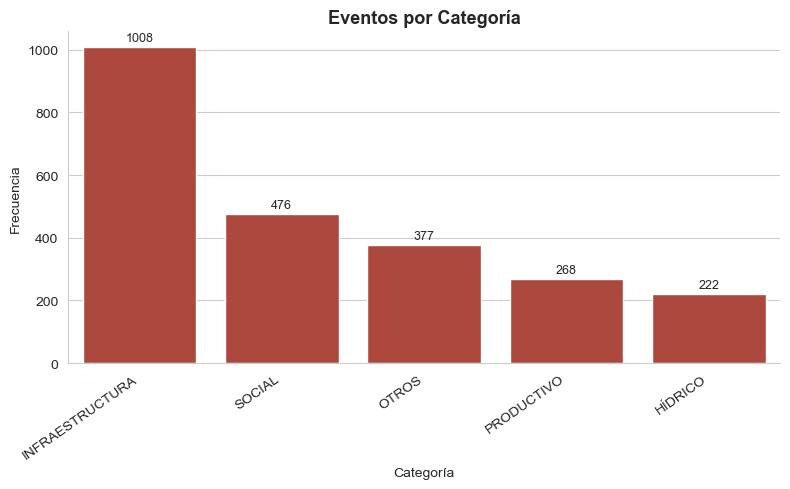

In [19]:
dist_eventos = (
    df.groupby("categoria")
      .agg(num_eventos=("categoria", "size"),
           proporcion=("categoria", lambda x: len(x) / len(df)))
      .reset_index()
      .sort_values("num_eventos", ascending=False)
)

print("\nDistribución de Eventos por Categoría\n")
print(dist_eventos)

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=dist_eventos,
    x="categoria",
    y="num_eventos",
    color="#C0392B"
)

ax.bar_label(ax.containers[0], fontsize=9, padding=2)

plt.title("Eventos por Categoría", fontsize=13, weight="bold")
plt.xlabel("Categoría")
plt.ylabel("Frecuencia")

plt.xticks(rotation=35, ha="right")
sns.despine()

plt.tight_layout()
plt.show()



Dado que la proporción de Obras, Energía y Otros resulta mucho menor que las otras se eliminarán

In [40]:

df.to_csv('../data/clean/datos_limpios.csv')

#### Distribución de Daños según la Categoría

In [21]:
dist_dano = (
    df.groupby("categoria")
      .agg(
          num_eventos=("total", "count"),
          total_danos=("total", "sum"),
          dano_promedio=("total", "mean"),
          dano_mediano=("total", "median"),
          dano_maximo=("total", "max")
      )
      .reset_index()
)

dist_dano["proporcion_dano_total"] = (
    dist_dano["total_danos"] / df["total"].sum()
)
dist_dano = dist_dano.sort_values("total_danos", ascending=False)

print("Distribución de Eventos por Monto de Daños")
print(dist_dano)


Distribución de Eventos por Monto de Daños
         categoria  num_eventos   total_danos  dano_promedio  dano_mediano  \
1  INFRAESTRUCTURA         1008  8.517943e+11   8.450340e+08   230000000.0   
2       PRODUCTIVO          268  1.966705e+11   7.338450e+08   163558408.0   
3           SOCIAL          476  1.697326e+11   3.565812e+08    48672107.0   
0          HÍDRICO          222  1.176841e+11   5.301086e+08   117532372.0   

    dano_maximo  proporcion_dano_total  
1  3.064761e+10               0.637627  
2  1.547991e+10               0.147221  
3  1.290968e+10               0.127057  
0  2.155322e+10               0.088095  


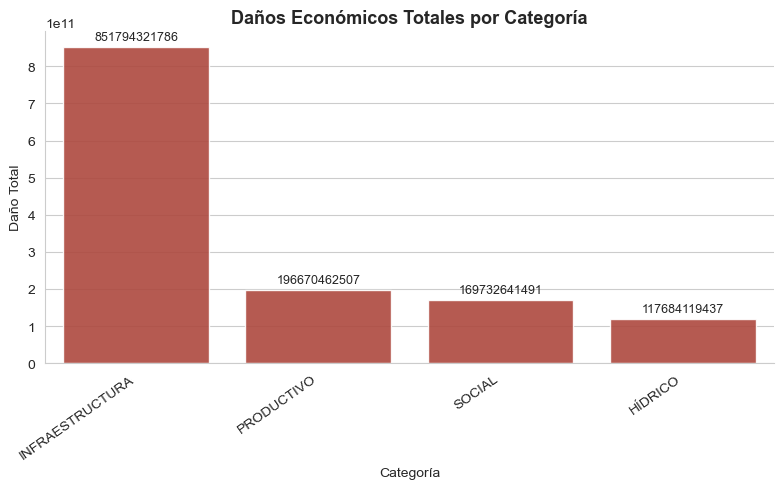

In [22]:
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=dist_dano,
    x="categoria",
    y="total_danos",
    color="#C0392B",
    alpha=0.9
)

ax.bar_label(ax.containers[0], fmt="%.0f", padding=3, fontsize=9)

plt.title("Daños Económicos Totales por Categoría", fontsize=13, fontweight="bold")
plt.xlabel("Categoría")
plt.ylabel("Daño Total")

plt.xticks(rotation=35, ha="right")
sns.despine()

plt.tight_layout()
plt.show()

#### Distribución de Eventos por Provincia

In [23]:
dist_lugar = (
    df.groupby("provincia")
      .size()
      .reset_index(name="num_eventos")
      .sort_values("num_eventos", ascending=False)
)

print("Distribución de Eventos por Provincia")
print(dist_lugar)


Distribución de Eventos por Provincia
    provincia  num_eventos
0    San José          426
4  Guanacaste          399
5  Puntarenas          390
1    Alajuela          329
6       Limón          178
2     Cartago          150
3     Heredia          102


C:\Users\andre\AppData\Local\Temp\ipykernel_44604\1251530825.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("provincia")


C:\Users\andre\AppData\Local\Temp\ipykernel_44604\1000809114.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


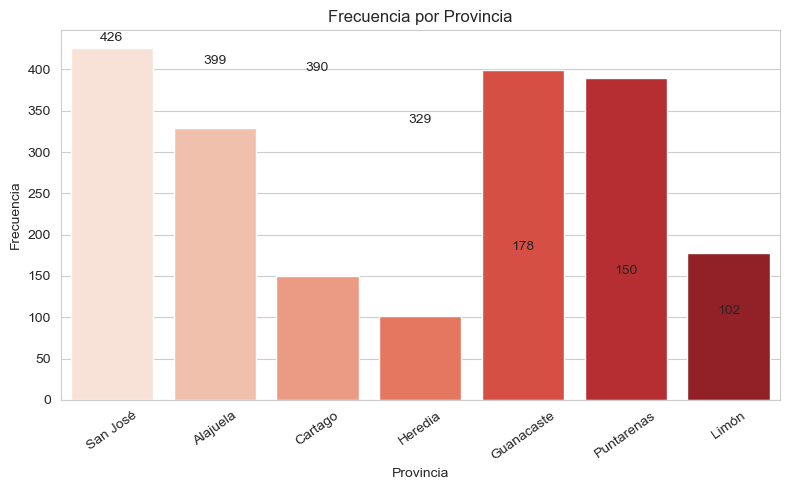

In [24]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=dist_lugar,
    x="provincia",
    y="num_eventos",
    palette="Reds"
)

for i, v in enumerate(dist_lugar["num_eventos"]):
    plt.text(i, v*1.02, f"{v:,.0f}", ha="center")

plt.title("Frecuencia por Provincia")
plt.xlabel("Provincia")
plt.ylabel("Frecuencia")
plt.xticks(rotation=35)
plt.tight_layout()
plt.show()


#### Series de Tiempo por Provincia

C:\Users\andre\AppData\Local\Temp\ipykernel_44604\796937078.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["ano", "provincia"])


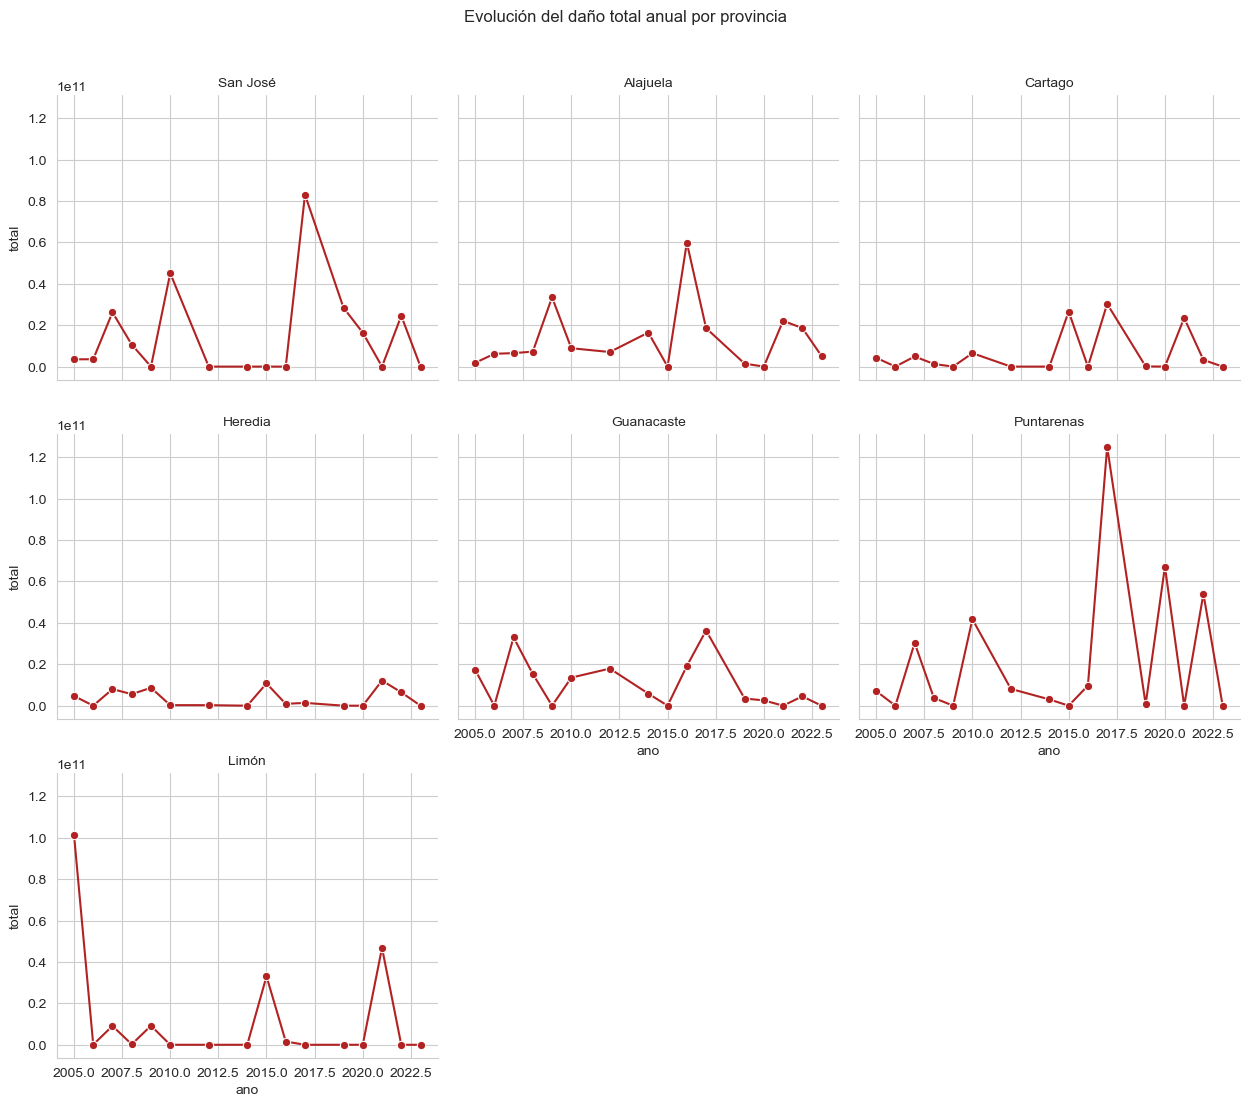

In [25]:
serie_provincia = (
    df.groupby(["ano", "provincia"])
      .agg(total=("total", "sum"), n_eventos=("total", "count"))
      .reset_index()
)

g = sns.relplot(
    data=serie_provincia,
    x="ano", y="total",
    col="provincia",
    kind="line", col_wrap=3,
    height=3.5, aspect=1.2,
    marker="o", color="firebrick"
)

g.set_titles("{col_name}")
g.fig.suptitle("Evolución del daño total anual por provincia", y=1.05)
plt.show()


#### Análisis de pérdidas por año

In [26]:
perdidas_anuales = df.groupby('ano')['total'].sum().sort_index()
print(perdidas_anuales)

ano
2005    1.403013e+11
2006    9.854203e+09
2007    1.180839e+11
2008    4.397571e+10
2009    5.132381e+10
2010    1.160501e+11
2012    3.332445e+10
2014    2.531097e+10
2015    7.042332e+10
2016    9.122739e+10
2017    2.946589e+11
2019    3.411893e+10
2020    8.612921e+10
2021    1.045718e+11
2022    1.114318e+11
2023    5.095822e+09
Name: total, dtype: float64


In [27]:
import plotly.graph_objects as go

df_plot = perdidas_anuales.reset_index()
df_plot.columns = ["Año", "Pérdidas"]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_plot["Año"],
    y=df_plot["Pérdidas"],
    mode="lines+markers",
    line=dict(color="royalblue", width=2),
    marker=dict(size=8),
    name="Pérdidas"
))

fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            showactive=True,
            buttons=list([
                dict(label="Todos",
                     method="relayout",
                     args=[{"xaxis.range": [df_plot["Año"].min(), df_plot["Año"].max()]}]),
                dict(label="Últimos 10 años",
                     method="relayout",
                     args=[{"xaxis.range": [df_plot["Año"].max()-10, df_plot["Año"].max()]}]),
                dict(label="Últimos 5 años",
                     method="relayout",
                     args=[{"xaxis.range": [df_plot["Año"].max()-5, df_plot["Año"].max()]}]),
            ])
        )
    ]
)

fig.update_layout(
    width=1000,
    height=500,
    template="simple_white",
    title="Pérdidas anuales por desastres naturales en Costa Rica",
    xaxis_title="Año",
    yaxis_title="Pérdidas totales",
    hovermode="x unified"
)

fig.show()



In [28]:
perdidas_anuales.describe()

count    1.600000e+01
mean     8.349260e+10
std      7.025775e+10
min      5.095822e+09
25%      3.392031e+10
50%      7.827627e+10
75%      1.125864e+11
max      2.946589e+11
Name: total, dtype: float64

#### Análisis de pérdidas por tipología

In [29]:
perdidas_tipologia = df.groupby('tipologia')['total'].sum().sort_values()
print(perdidas_tipologia)

KeyError: 'tipologia'

In [ ]:
df_plot = perdidas_tipologia.reset_index()
df_plot.columns = ["Tipología", "Pérdidas"]

fig = go.Figure()

'''
for i, row in df_plot.iterrows():
    fig.add_trace(go.Bar(
        x=[row["Pérdidas"]],
        y=[row["Tipología"]],
        orientation='h',
        marker=dict(color="royalblue"),
        name=row["Tipología"],
        visible=True
    ))
'''

fig.update_layout(
    width=800,
    height=500,
    template="simple_white",
    xaxis_title="Pérdida en Colones",
    yaxis_title="Tipología",
    title="Distribución de Pérdidas por Tipología del Desastre Natural en Costa Rica"
)

fig.show()

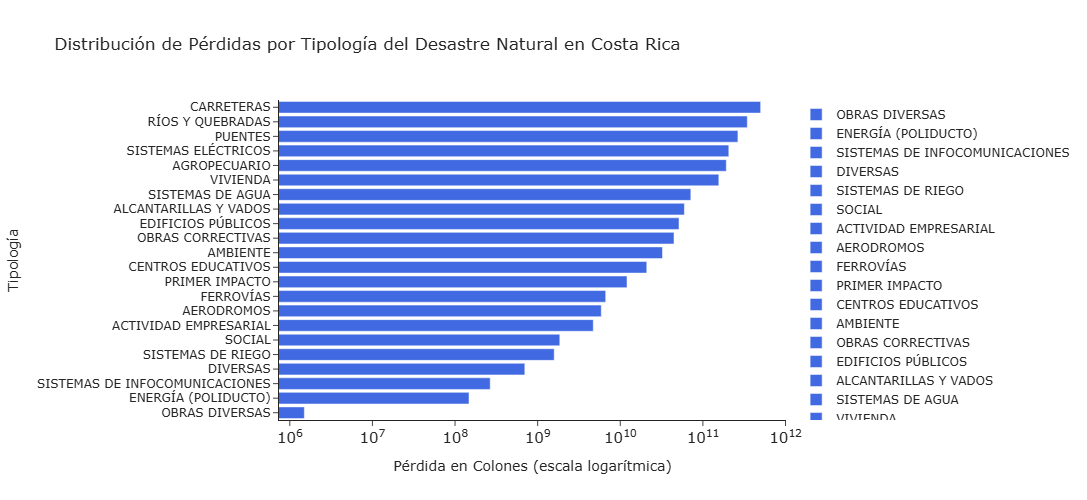

In [ ]:
df_plot = perdidas_tipologia.reset_index()
df_plot.columns = ["Tipología", "Pérdidas"]

fig = go.Figure()
for i, row in df_plot.iterrows():
    fig.add_trace(go.Bar(
        x=[row["Pérdidas"]],
        y=[row["Tipología"]],
        orientation="h",
        marker=dict(color="royalblue"),
        name=row["Tipología"]
    ))

fig.update_layout(
    width=800,
    height=500,
    template="simple_white",
    xaxis_title="Pérdida en Colones (escala logarítmica)",
    yaxis_title="Tipología",
    title="Distribución de Pérdidas por Tipología del Desastre Natural en Costa Rica",
)

fig.update_xaxes(type="log", exponentformat="power")

fig.show()

#### Análisis por Provincia

In [ ]:
perdidas_provincia = df.groupby('provincia')['total'].sum().sort_values()
print(perdidas_provincia)

provincia
Heredia       6.935086e+10
Cartago       1.166958e+11
Guanacaste    1.876880e+11
San José      2.886693e+11
Limón         3.174224e+11
Alajuela      4.908171e+11
Puntarenas    5.072952e+11
Name: total, dtype: float64


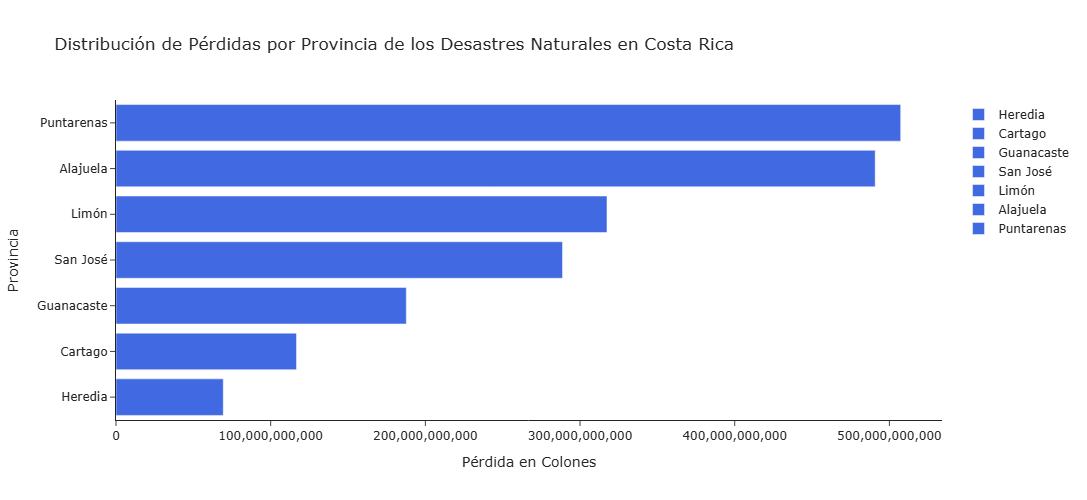

In [ ]:
df_plot = perdidas_provincia.reset_index()
df_plot.columns = ["Provincia", "Pérdidas"]

fig = go.Figure()

for i, row in df_plot.iterrows():
    fig.add_trace(go.Bar(
        x=[row["Pérdidas"]],
        y=[row["Provincia"]],
        orientation="h",
        marker=dict(color="royalblue"),  
        name=row["Provincia"]
    ))

fig.update_layout(
    width=800,
    height=500,
    template="simple_white",
    xaxis_title="Pérdida en Colones",
    yaxis_title="Provincia",
    title="Distribución de Pérdidas por Provincia de los Desastres Naturales en Costa Rica",
)

fig.update_xaxes(type="linear", exponentformat="none")

fig.show()


In [ ]:
combinado_provincia_tipologia = df.groupby(['tipologia', 'provincia'])['total'].sum().reset_index().sort_values(by='total')
orden_provincias = ["San José", "Alajuela", "Cartago", "Heredia", "Guanacaste", "Puntarenas", "Limón"]
combinado_provincia_tipologia['provincia'] = pd.Categorical(
    combinado_provincia_tipologia['provincia'],
    categories=orden_provincias,
    ordered=True
)
print(combinado_provincia_tipologia)

                          tipologia   provincia         total
42                         DIVERSAS     Heredia  1.000000e+05
62                   OBRAS DIVERSAS  Guanacaste  1.500000e+06
93   SISTEMAS DE INFOCOMUNICACIONES  Guanacaste  1.542958e+06
103             SISTEMAS ELÉCTRICOS     Heredia  6.210540e+06
22                         AMBIENTE     Heredia  7.560000e+06
..                              ...         ...           ...
75                          PUENTES  Puntarenas  9.944506e+10
81                 RÍOS Y QUEBRADAS       Limón  1.067296e+11
82                 RÍOS Y QUEBRADAS  Puntarenas  1.326880e+11
30                       CARRETERAS  Puntarenas  1.427340e+11
100             SISTEMAS ELÉCTRICOS    Alajuela  2.055030e+11

[121 rows x 3 columns]


In [ ]:
import plotly.graph_objects as go

for prov in combinado_provincia_tipologia['provincia'].unique():
    tabla = combinado_provincia_tipologia[combinado_provincia_tipologia['provincia'] == prov]

    fig = go.Figure()
    
    for i, row in tabla.iterrows():
        fig.add_trace(go.Bar(
            x=[row["total"]],
            y=[row["tipologia"]],
            orientation="h",
            marker=dict(color="royalblue"),
            name=row["tipologia"]
        ))

    fig.update_layout(
        width=900,
        height=500,
        template="simple_white",
        xaxis_title="Pérdida en Colones (escala logarítmica)",
        yaxis_title="Tipología",
        title=f"Distribución de Pérdidas por Tipología del Desastre Natural en {prov}, Costa Rica"
    )
    fig.update_xaxes(type="log", exponentformat="power")

    fig.show()


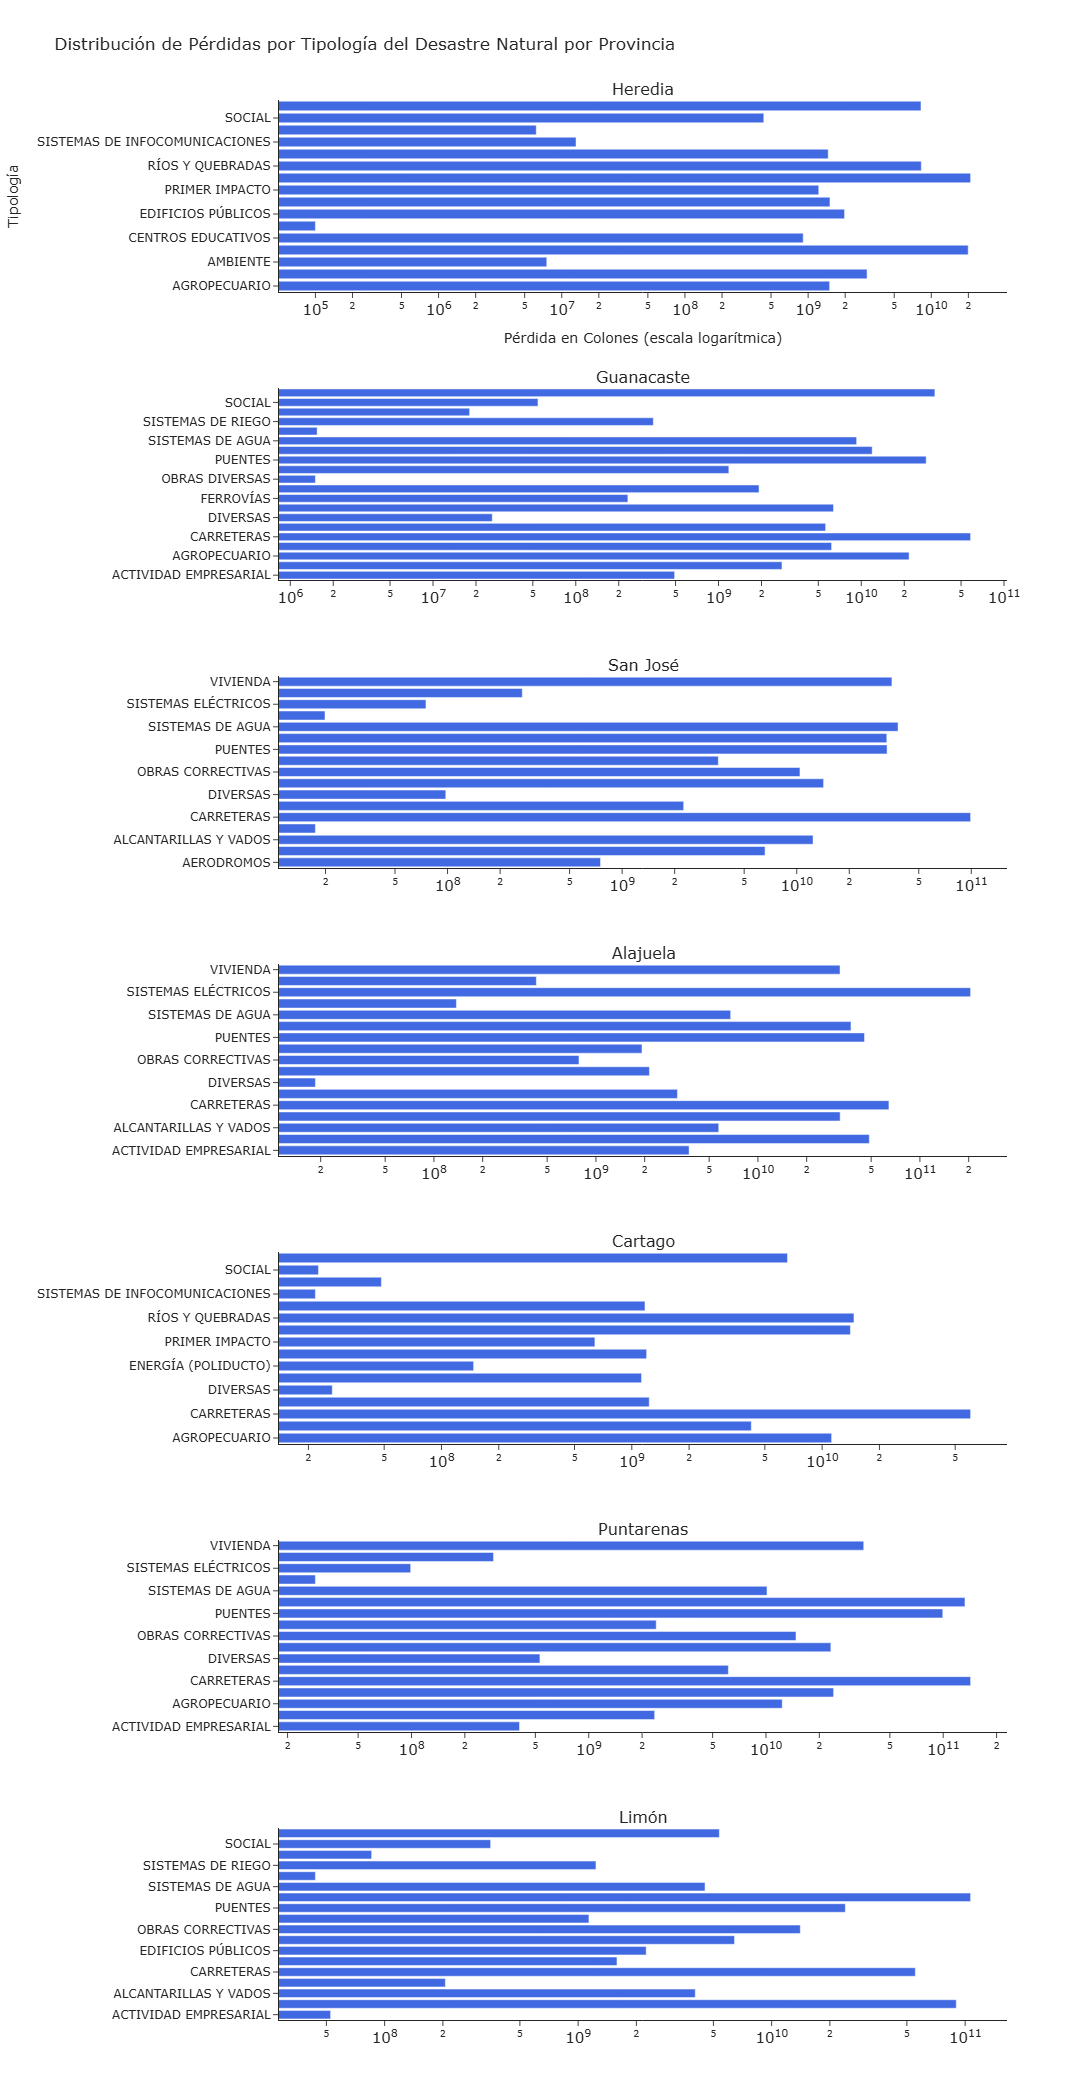

In [ ]:
provincias = combinado_provincia_tipologia['provincia'].unique()
ncols = 1
nrows = len(provincias)

fig = make_subplots(
    rows=nrows,
    cols=ncols,
    shared_xaxes=False,
    shared_yaxes=False,
    subplot_titles=provincias,
    vertical_spacing=0.05
)

for idx, prov in enumerate(provincias):
    tabla = combinado_provincia_tipologia[combinado_provincia_tipologia['provincia'] == prov].sort_values('tipologia')
    row = idx + 1
    col = 1

    for i, row_data in tabla.iterrows():
        fig.add_trace(
            go.Bar(
                x=[row_data['total']],
                y=[row_data['tipologia']],
                orientation='h',
                marker=dict(color='royalblue'),
                name=row_data['tipologia'],
                showlegend=False
            ),
            row=row,
            col=col
        )

fig.update_layout(
    width=1000,
    height=300*nrows, 
    template="simple_white",
    title="Distribución de Pérdidas por Tipología del Desastre Natural por Provincia",
    xaxis_title="Pérdida en Colones (escala logarítmica)",
    yaxis_title="Tipología",
    legend=dict(itemclick=False, itemdoubleclick=False)
)
for i in range(1, nrows+1):
    fig.update_xaxes(type="log", exponentformat="power", row=i, col=1)
    fig.update_yaxes(row=i, col=1)

fig.show()

In [ ]:
combinado_provincia_ano = df.groupby(['ano', 'provincia'])['total'].sum().reset_index().sort_values(by='total')
orden_provincias = ["San José", "Alajuela", "Cartago", "Heredia", "Guanacaste", "Puntarenas", "Limón"]
combinado_provincia_ano['provincia'] = pd.Categorical(
    combinado_provincia_ano['provincia'],
    categories=orden_provincias,
    ordered=True
)
print(combinado_provincia_ano)

     ano   provincia         total
55  2019     Cartago  1.042932e+08
21  2008       Limón  2.222518e+08
35  2012     Heredia  2.500000e+08
30  2010     Heredia  2.650000e+08
8   2006       Limón  6.413524e+08
..   ...         ...           ...
65  2021       Limón  1.101644e+11
4   2005       Limón  1.138138e+11
70  2022  Puntarenas  1.143851e+11
52  2017  Puntarenas  1.411862e+11
24  2009    Alajuela  2.713196e+11

[73 rows x 3 columns]


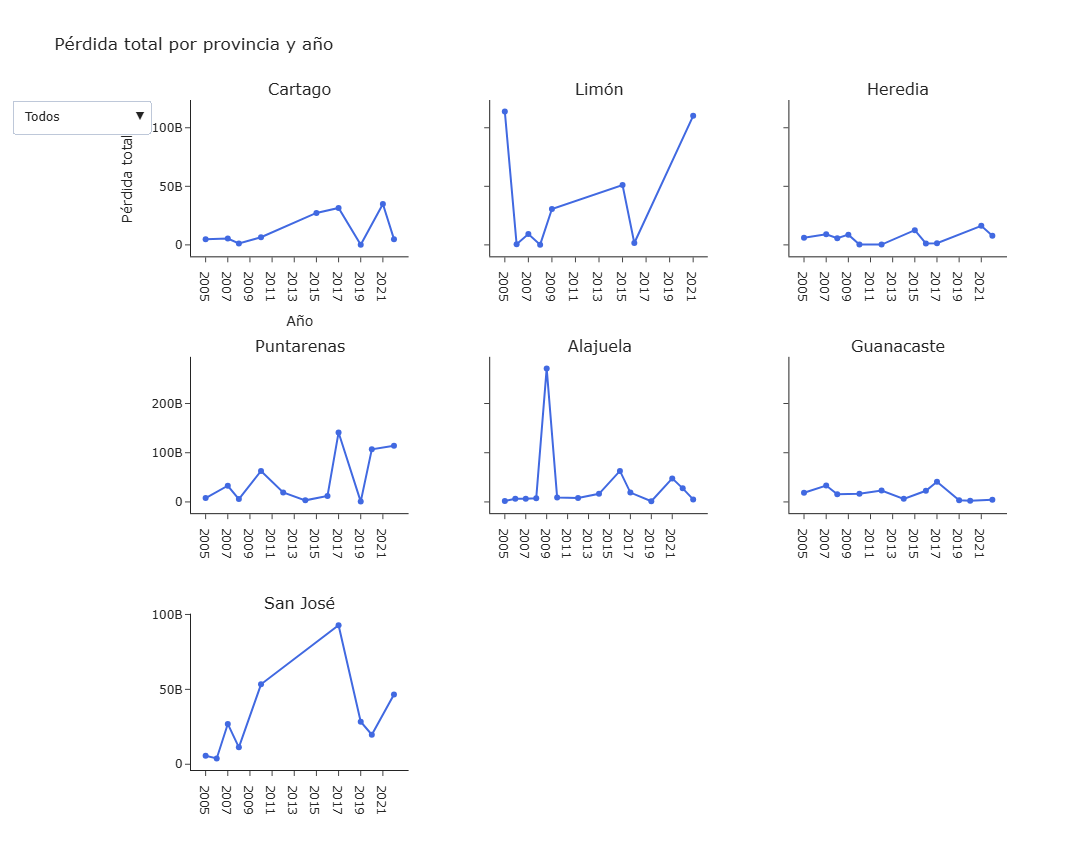

In [ ]:
anos = np.arange(2005, 2023, 2)
provincias = combinado_provincia_ano['provincia'].unique()
ncols = 3
nrows = (len(provincias) + ncols - 1) // ncols

fig = make_subplots(
    rows=nrows,
    cols=ncols,
    shared_yaxes=True, 
    subplot_titles=provincias,
    horizontal_spacing=0.1,
    vertical_spacing=0.15
)

for idx, prov in enumerate(provincias):
    tabla = combinado_provincia_ano[combinado_provincia_ano['provincia'] == prov]

    tabla = tabla.sort_values('ano')

    row = idx // ncols + 1
    col = idx % ncols + 1

    fig.add_trace(
        go.Scatter(
            x=tabla['ano'],
            y=tabla['total'],
            mode='lines+markers',
            line=dict(color='royalblue', width=2),
            marker=dict(size=6),
            name=prov,
            showlegend=False
        ),
        row=row,
        col=col
    )

    fig.update_xaxes(
        tickvals=anos,
        row=row,
        col=col
    )

fig.update_layout(
    width=1200,
    height=400 + 150*nrows,  
    template="simple_white",
    title="Pérdida total por provincia y año",
    xaxis_title="Año",
    yaxis_title="Pérdida total",
    hovermode="x unified"
)

fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            showactive=True,
            buttons=list([
                dict(label="Todos",
                     method="relayout",
                     args=[{"xaxis.range": [anos.min(), anos.max()]}]),
                dict(label="Últimos 10 años",
                     method="relayout",
                     args=[{"xaxis.range": [anos.max()-10, anos.max()]}]),
                dict(label="Últimos 5 años",
                     method="relayout",
                     args=[{"xaxis.range": [anos.max()-5, anos.max()]}]),
            ])
        )
    ]
)

fig.show()


#### Distribución en General

Para hacer los histogramas voy a usar el ancho de banda óptimo de Freedman-Diaconis que es

$$
h = 2\cdot \dfrac{IQR}{n^{1/3}}
$$

2711


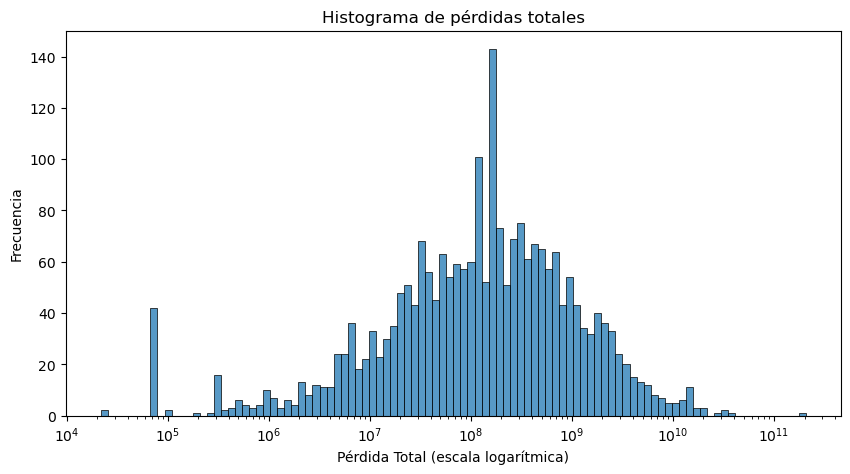

In [ ]:
n = len(df['total'])
iqr = np.percentile(df['total'], 75) - np.percentile(df['total'], 25)
bin_width = 2 * iqr / n**(1/3)
num_bins = int(np.ceil((df['total'].max() - df['total'].min()) / bin_width))
print(num_bins)

plt.figure(figsize=(10,5))
sns.histplot(df['total'], bins=100, log_scale=True)
plt.title("Histograma de pérdidas totales")
plt.xlabel('Pérdida Total (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.show()

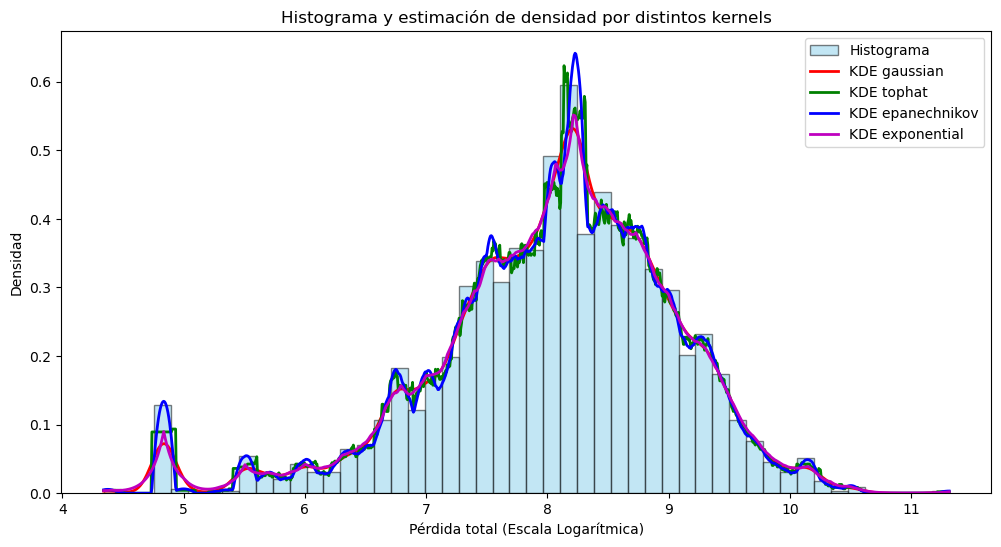

In [ ]:
perdidas = df['total'].dropna()

perdidas_positivas = perdidas[perdidas > 0]
perdidas_log = np.log10(perdidas_positivas)

perdidas_array = perdidas_log.to_numpy()[:, np.newaxis]
x_plot_log = np.linspace(perdidas_log.min(), perdidas_log.max(), 1000)[:, np.newaxis]

plt.figure(figsize=(12,6))

plt.hist(perdidas_log, bins=50, density=True, alpha=0.5, 
         color='skyblue', edgecolor='black', label='Histograma')

kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential']
colors = ['r', 'g', 'b', 'm']

for kernel, color in zip(kernels, colors):
    kde = KernelDensity(kernel=kernel, bandwidth=0.1)  
    kde.fit(perdidas_array)
    log_dens = kde.score_samples(x_plot_log)
    pdf = np.exp(log_dens)
    
    plt.plot(x_plot_log[:,0], pdf, color=color, lw=2, label=f'KDE {kernel}')

plt.xlabel("Pérdida total (Escala Logarítmica)")
plt.ylabel("Densidad")
plt.title("Histograma y estimación de densidad por distintos kernels")
plt.legend()
plt.show()

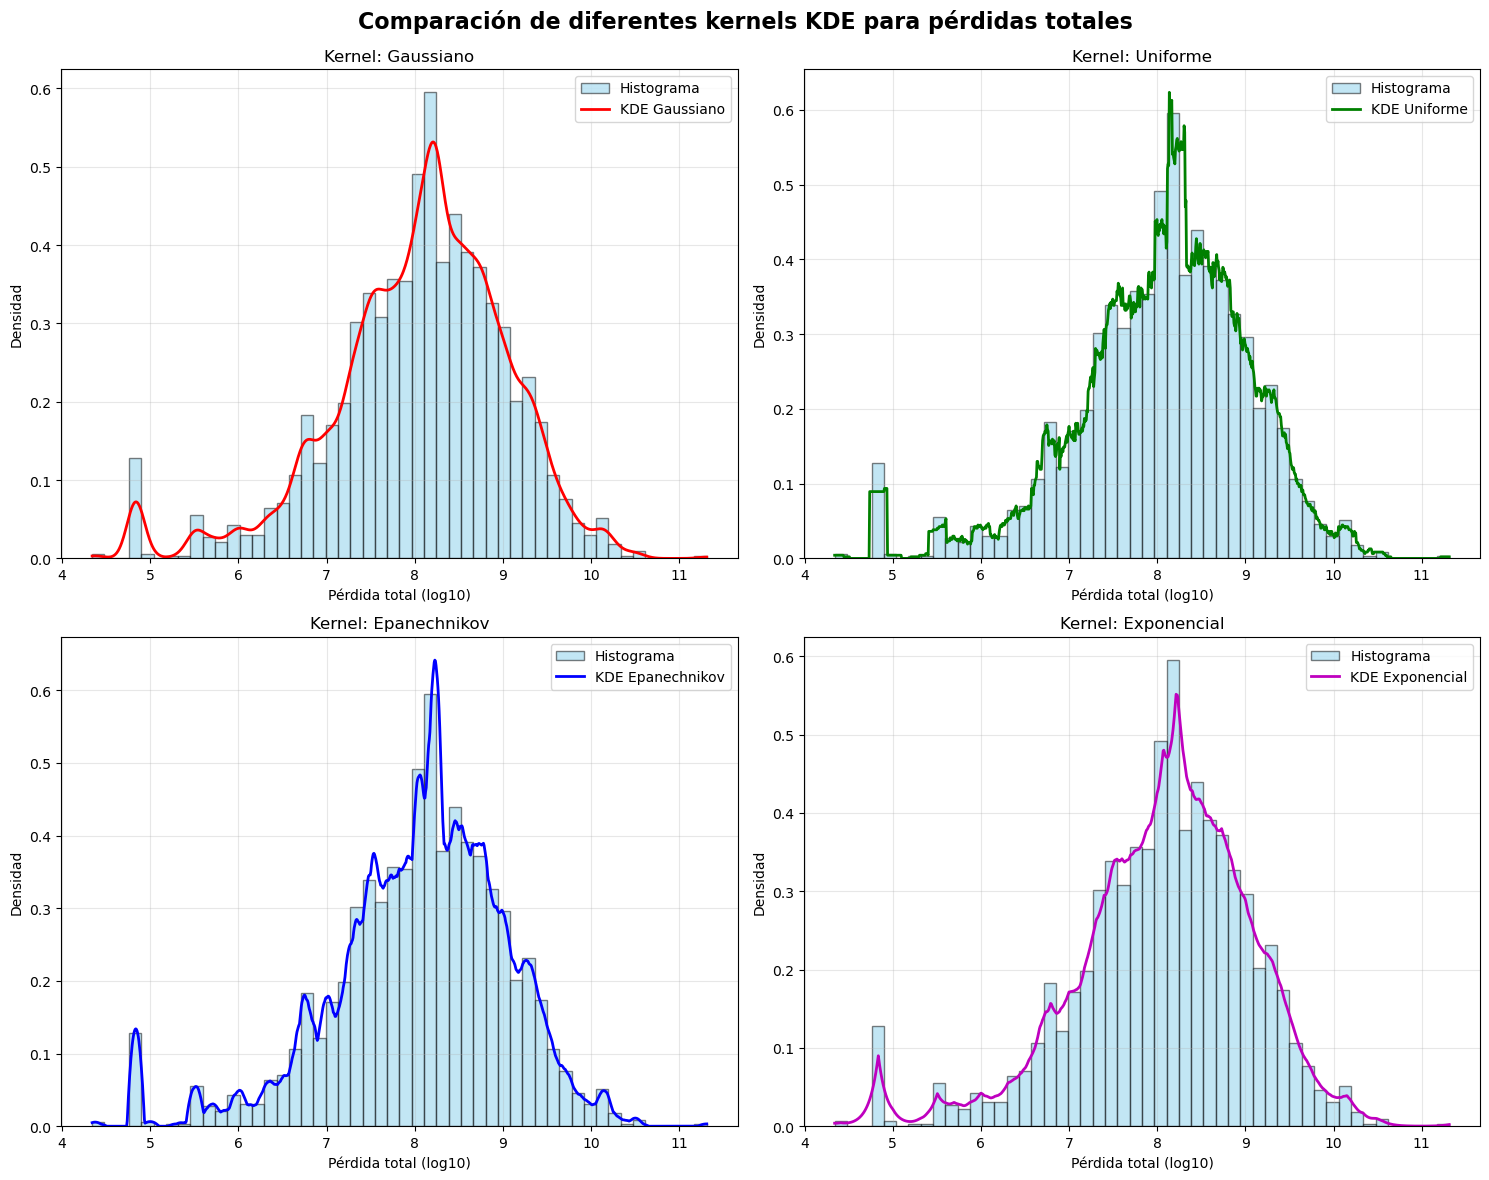

In [ ]:
perdidas = df['total'].dropna()
perdidas_positivas = perdidas[perdidas > 0]
perdidas_log = np.log10(perdidas_positivas)

perdidas_array = perdidas_log.to_numpy()[:, np.newaxis]
x_plot_log = np.linspace(perdidas_log.min(), perdidas_log.max(), 1000)[:, np.newaxis]

kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential']
colors = ['r', 'g', 'b', 'm']
kernel_names = ['Gaussiano', 'Uniforme', 'Epanechnikov', 'Exponencial']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación de diferentes kernels KDE para pérdidas totales', 
             fontsize=16, fontweight='bold')

axes = axes.flatten()

for i, (kernel, color, kernel_name) in enumerate(zip(kernels, colors, kernel_names)):
    axes[i].hist(perdidas_log, bins=50, density=True, alpha=0.5, 
                color='skyblue', edgecolor='black', label='Histograma')
    
    kde = KernelDensity(kernel=kernel, bandwidth=0.1)  
    kde.fit(perdidas_array)
    log_dens = kde.score_samples(x_plot_log)
    pdf = np.exp(log_dens)
    
    axes[i].plot(x_plot_log[:,0], pdf, color=color, lw=2, label=f'KDE {kernel_name}')
    
    axes[i].set_xlabel("Pérdida total (log10)")
    axes[i].set_ylabel("Densidad")
    axes[i].set_title(f"Kernel: {kernel_name}")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

perdidas = df['total'].dropna()
perdidas_positivas = perdidas[perdidas > 0]
perdidas_log = np.log10(perdidas_positivas)
perdidas_array = perdidas_log.values.reshape(-1, 1)

bandwidths = np.logspace(-2, 1, 20)

kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential']
best_scores = {}
best_bandwidths = {}

def kde_scorer(estimator, X):
    return estimator.score(X)

for kernel in kernels:
        grid = GridSearchCV(KernelDensity(kernel=kernel), {'bandwidth': bandwidths}, cv=10, scoring=kde_scorer) 
        grid.fit(perdidas_array)
        best_scores[kernel] = grid.best_score_
        best_bandwidths[kernel] = grid.best_params_['bandwidth']
        print(f"Kernel {kernel:12s}: Score = {grid.best_score_:8.2f}, Bandwidth = {grid.best_params_['bandwidth']:.4f}")

Kernel gaussian    : Score =  -328.99, Bandwidth = 0.1833
Kernel tophat      : Score =  -329.71, Bandwidth = 0.7848
Kernel epanechnikov: Score =  -329.76, Bandwidth = 0.7848
Kernel exponential : Score =  -324.53, Bandwidth = 0.0298


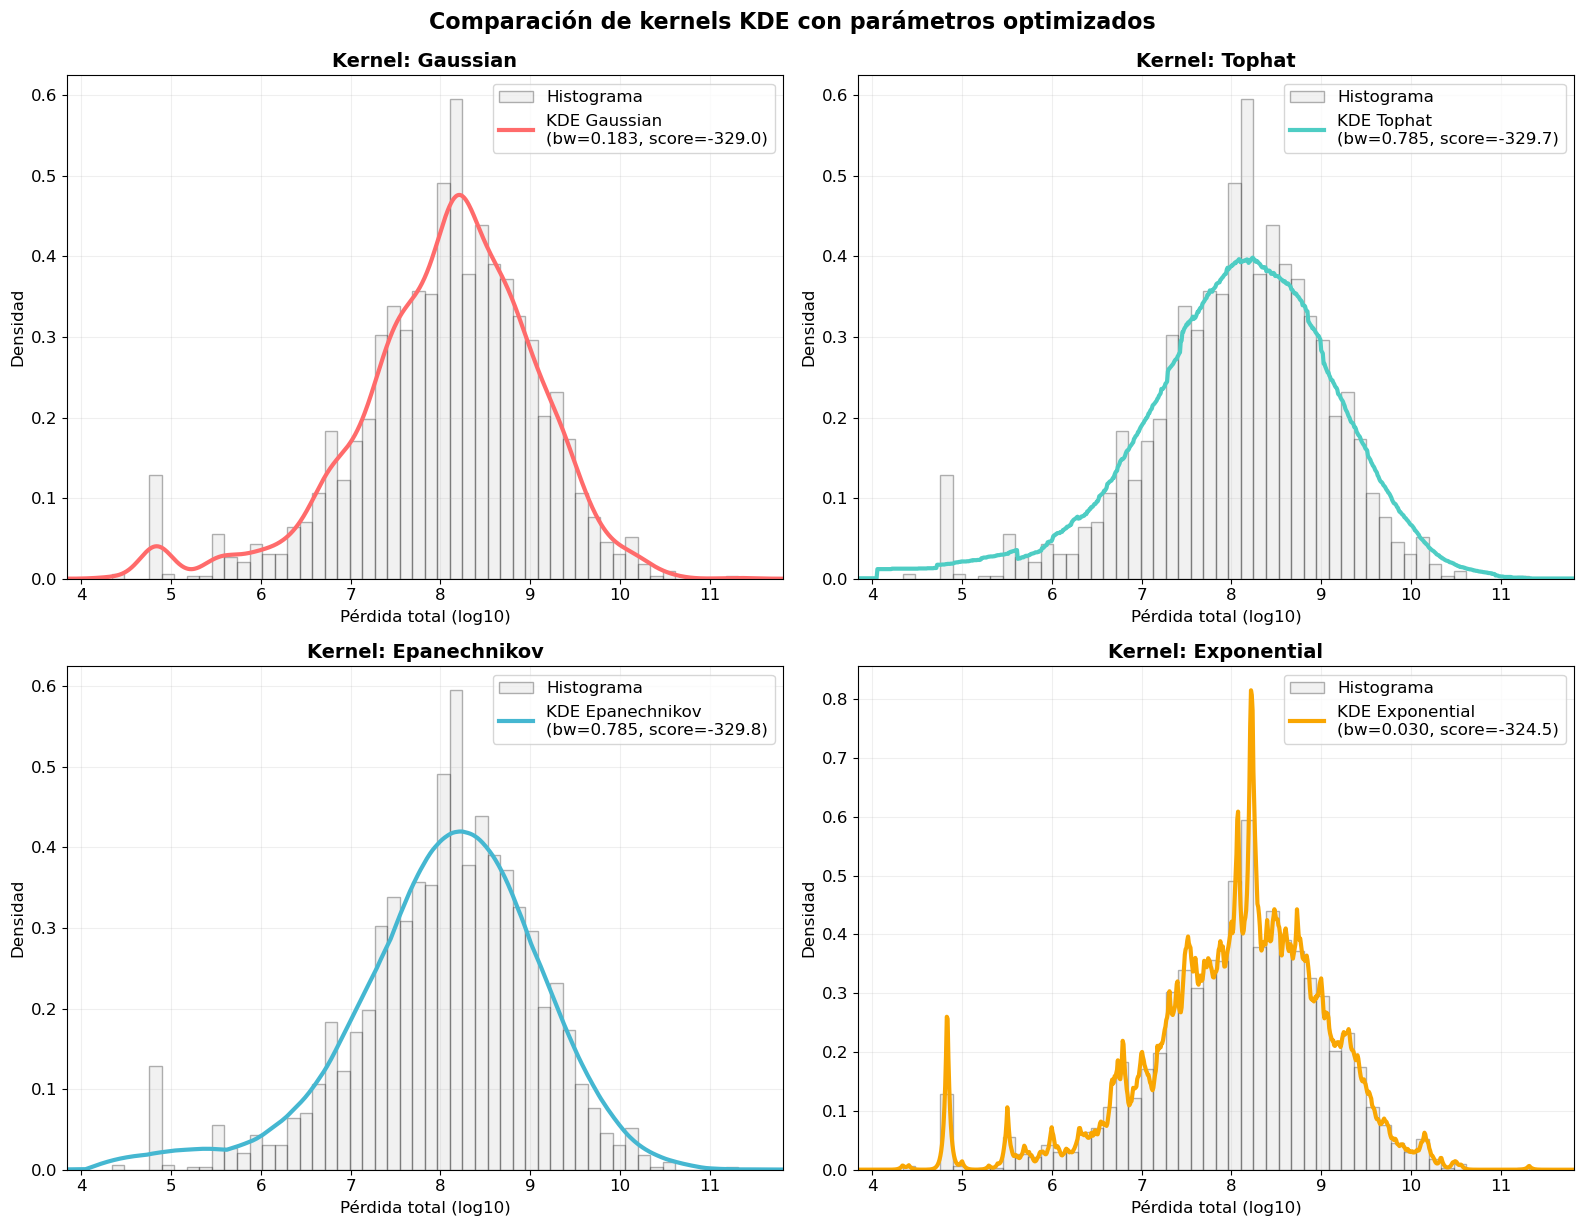

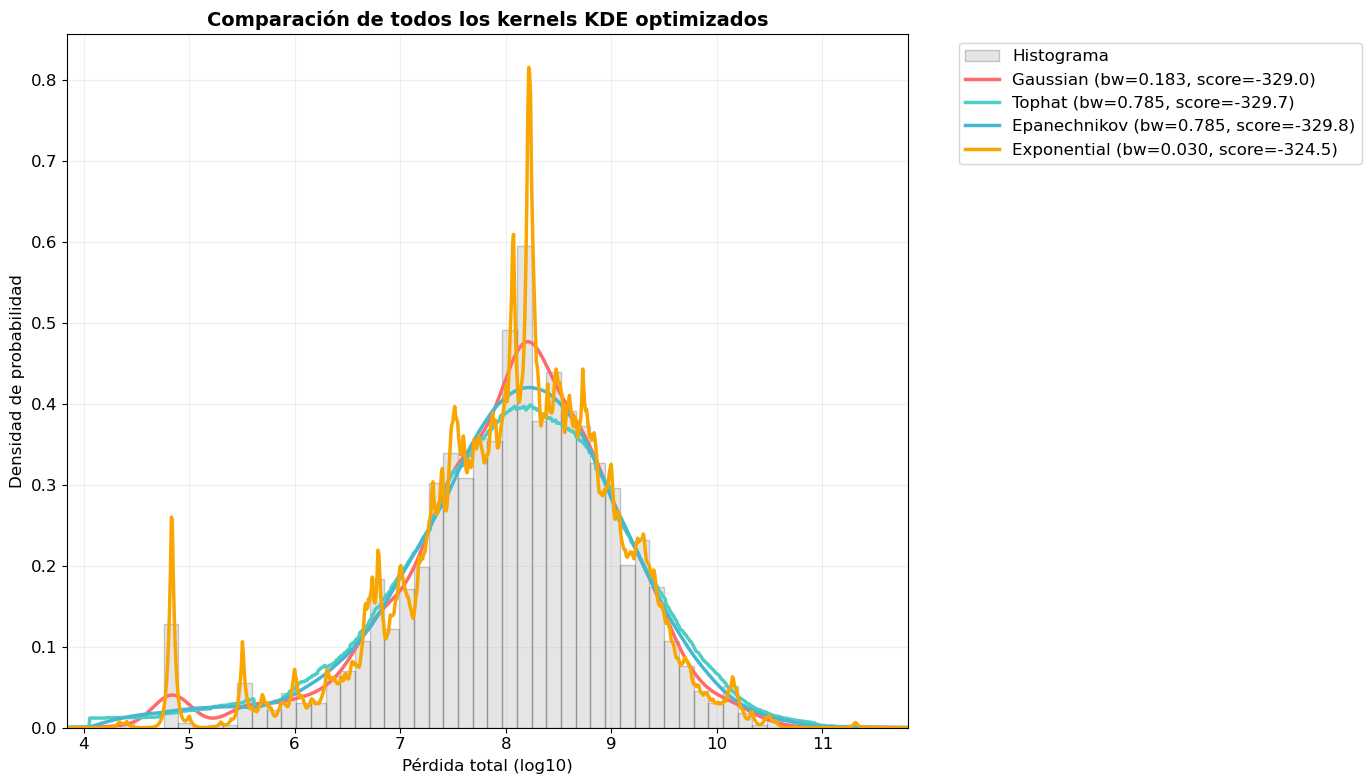

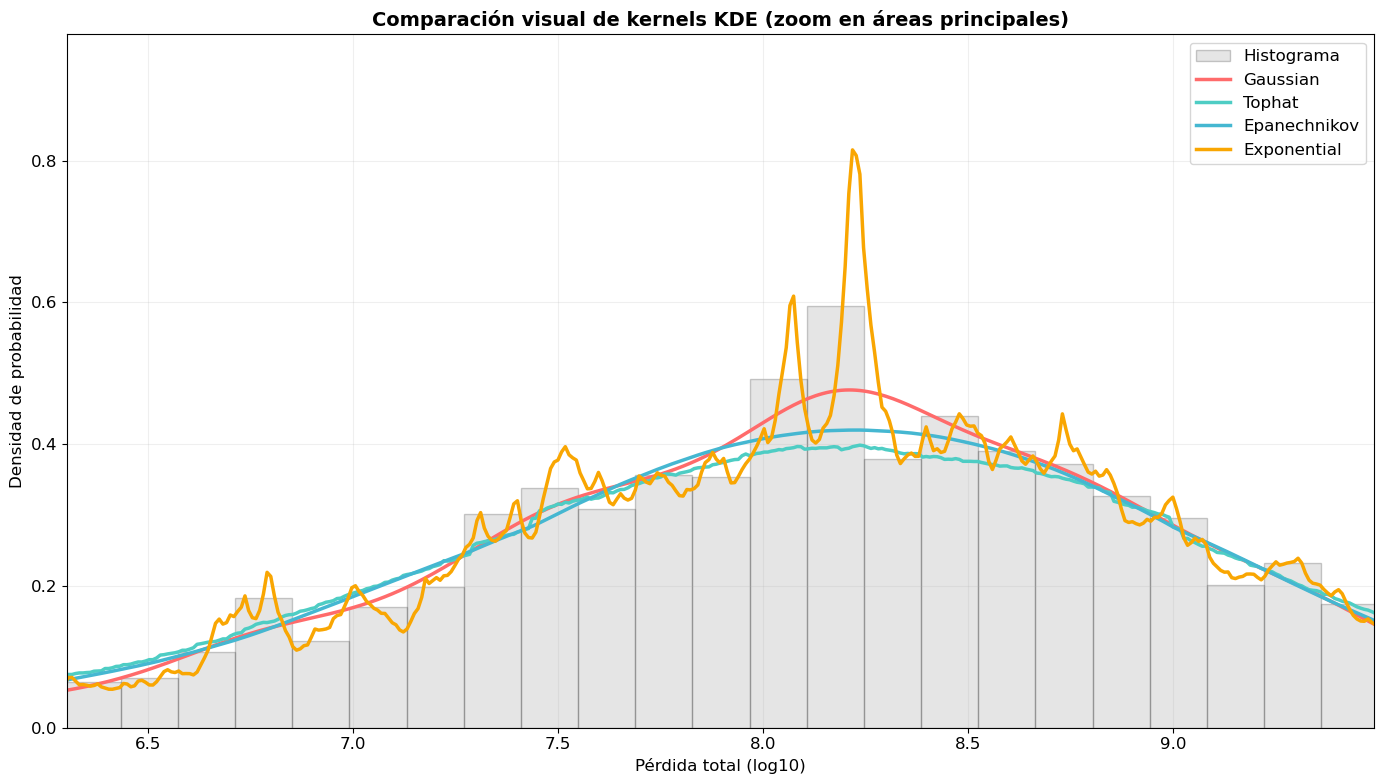

KERNEL         | BANDWIDTH | SCORE     | DIFERENCIA
gaussian     |   0.1833  |  -328.99  |   -4.46
tophat       |   0.7848  |  -329.71  |   -5.18
epanechnikov |   0.7848  |  -329.76  |   -5.23
exponential  |   0.0298  |  -324.53  |    0.00


In [ ]:
# Este código hace lo mismo que el otro mío pero los grafica, fuente: internet no recuerdo la página

plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 12

x_plot_log = np.linspace(perdidas_log.min() - 1, perdidas_log.max() + 1, 1000)[:, np.newaxis]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#F9A602']
kernel_names = ['Gaussian', 'Tophat', 'Epanechnikov', 'Exponential']

for i, (kernel, color, kernel_name) in enumerate(zip(kernels, colors, kernel_names)):
    bw = best_bandwidths[kernel]
    score = best_scores[kernel]
    
    kde = KernelDensity(kernel=kernel, bandwidth=bw)
    kde.fit(perdidas_array)
    
    log_dens = kde.score_samples(x_plot_log)
    pdf = np.exp(log_dens)
    
    axes[i].hist(perdidas_log, bins=50, density=True, alpha=0.3, 
                color='lightgray', edgecolor='black', label='Histograma')
    
    axes[i].plot(x_plot_log[:, 0], pdf, color=color, lw=3, 
                label=f'KDE {kernel_name}\n(bw={bw:.3f}, score={score:.1f})')
    
    axes[i].set_xlabel('Pérdida total (log10)')
    axes[i].set_ylabel('Densidad')
    axes[i].set_title(f'Kernel: {kernel_name}', fontweight='bold', fontsize=14)
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.2)
    axes[i].set_xlim([perdidas_log.min() - 0.5, perdidas_log.max() + 0.5])

plt.tight_layout()
plt.suptitle('Comparación de kernels KDE con parámetros optimizados', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

plt.figure(figsize=(14, 8))

plt.hist(perdidas_log, bins=50, density=True, alpha=0.2, 
         color='gray', edgecolor='black', label='Histograma')

for kernel, color, kernel_name in zip(kernels, colors, kernel_names):
    bw = best_bandwidths[kernel]
    score = best_scores[kernel]
    
    kde = KernelDensity(kernel=kernel, bandwidth=bw)
    kde.fit(perdidas_array)
    log_dens = kde.score_samples(x_plot_log)
    pdf = np.exp(log_dens)
    
    plt.plot(x_plot_log[:, 0], pdf, color=color, lw=2.5, 
             label=f'{kernel_name} (bw={bw:.3f}, score={score:.1f})')

plt.xlabel('Pérdida total (log10)', fontsize=12)
plt.ylabel('Densidad de probabilidad', fontsize=12)
plt.title('Comparación de todos los kernels KDE optimizados', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)
plt.xlim([perdidas_log.min() - 0.5, perdidas_log.max() + 0.5])
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))

plt.hist(perdidas_log, bins=50, density=True, alpha=0.2, 
         color='gray', edgecolor='black', label='Histograma')

for kernel, color, kernel_name in zip(kernels, colors, kernel_names):
    bw = best_bandwidths[kernel]
    
    kde = KernelDensity(kernel=kernel, bandwidth=bw)
    kde.fit(perdidas_array)
    log_dens = kde.score_samples(x_plot_log)
    pdf = np.exp(log_dens)
    
    plt.plot(x_plot_log[:, 0], pdf, color=color, lw=2.5, label=f'{kernel_name}')

plt.xlabel('Pérdida total (log10)', fontsize=12)
plt.ylabel('Densidad de probabilidad', fontsize=12)
plt.title('Comparación visual de kernels KDE (zoom en áreas principales)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.2)

plt.xlim([np.percentile(perdidas_log, 5), np.percentile(perdidas_log, 95)])
plt.ylim([0, 1.2 * np.max([np.exp(KernelDensity(kernel=k, bandwidth=best_bandwidths[k])
                          .fit(perdidas_array)
                          .score_samples(x_plot_log)) 
                          for k in kernels])])

plt.tight_layout()
plt.show()

print("KERNEL         | BANDWIDTH | SCORE     | DIFERENCIA")

best_score = max(best_scores.values())
for kernel in kernels:
    bw = best_bandwidths[kernel]
    score = best_scores[kernel]
    diff = score - best_score  
    print(f"{kernel:12s} | {bw:8.4f}  | {score:8.2f}  | {diff:7.2f}")
